In [1]:
# training a classic model on the Speechcommands dataset
# adapted from https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

/home/felix/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
import IPython.display as ipd
from tqdm.notebook import tqdm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [8]:
# load dataset
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate = 8000,
                                                                          batch_size = 256,
                                                                          batchsize_for_val =256,
                                                                          num_workers=5, 
                                                                          pin_memory=True)

In [9]:
train_set = train_loader.dataset
test_set = test_loader.dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_set[548]

Shape of waveform: torch.Size([1, 6826])
Sample rate of waveform: 16000


<IPython.core.display.Javascript object>


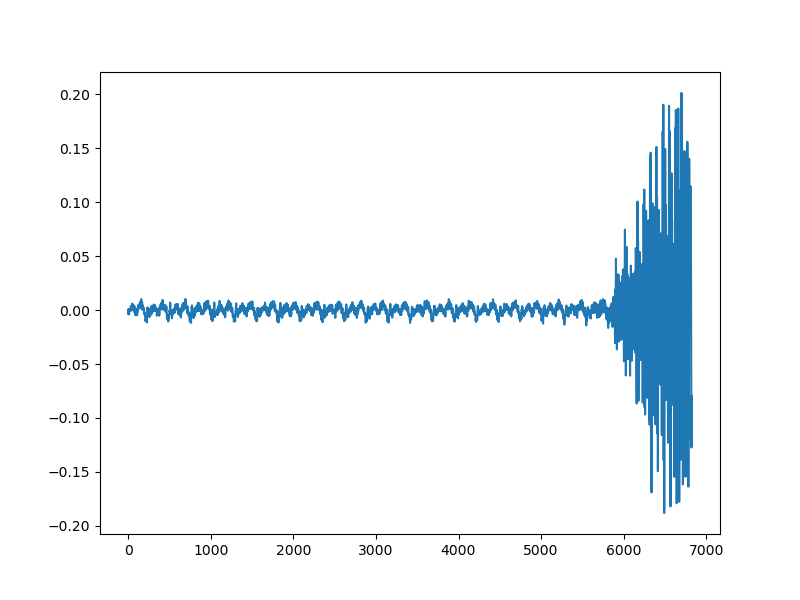

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

In [11]:
# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [12]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [13]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [14]:
### classic model

# class M5(nn.Module):
#     def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
#         super().__init__()
#         self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
#         self.bn1 = nn.BatchNorm1d(n_channel)
#         self.pool1 = nn.MaxPool1d(4)
#         self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
#         self.bn2 = nn.BatchNorm1d(n_channel)
#         self.pool2 = nn.MaxPool1d(4)
#         self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
#         self.bn3 = nn.BatchNorm1d(2 * n_channel)
#         self.pool3 = nn.MaxPool1d(4)
#         self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
#         self.bn4 = nn.BatchNorm1d(2 * n_channel)
#         self.pool4 = nn.MaxPool1d(4)
#         self.fc1 = nn.Linear(2 * n_channel, n_output)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(self.bn1(x))
#         x = self.pool1(x)
#         x = self.conv2(x)
# #         x = F.relu(self.bn2(x))
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = F.relu(self.bn3(x))
#         x = self.pool3(x)
#         x = self.conv4(x)
#         x = F.relu(self.bn4(x))
#         x = self.pool4(x)
#         x = F.avg_pool1d(x, x.shape[-1])
#         x = x.permute(0, 2, 1)
#         x = self.fc1(x)
#         return F.log_softmax(x, dim=2)

In [15]:
class FGN_M5(nn.Module):
    
    # changes:
    # nn.Conv1d -> fgnl.FGN_Conv1d
    # added g to conv inputs and outputs
    # make sure you pass g through the same pooling steps as x
    
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.fgn_conv1 = fgnl.FGN_Conv1d(in_channels=n_input, out_channels=n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.fgn_conv2 = fgnl.FGN_Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fgn_conv3 = fgnl.FGN_Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fgn_conv4 = fgnl.FGN_Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        
        #TODO change to self.pool1d_fgn() for each pooling of Gs

    def forward(self, x):
        x, g = self.fgn_conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        g = self.pool1(g)
        x, g = self.fgn_conv2(x, g)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        g = self.pool2(g)
        x, g = self.fgn_conv3(x ,g)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        g = self.pool3(g)
        x, _ = self.fgn_conv4(x, g)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [24]:
model = FGN_M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

FGN_M5(
  (fgn_conv1): FGN_Conv1d(
    (Conv1d): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  )
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv2): FGN_Conv1d(
    (Conv1d): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv3): FGN_Conv1d(
    (Conv1d): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  )
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv4): FGN_Conv1d(
    (Conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  )
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): Ma

In [17]:
lmbda_sigma = 1e-4
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [25]:
# pre training model sigmas
fgnl.sigmas_loss(model, covar_type='sphere')

tensor([598.8533], grad_fn=<DivBackward0>)

In [19]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target) + lmbda_sigma*fgnl.sigmas_loss(model, covar_type='sphere')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [20]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.793922
Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.942550
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.431046
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.113340
Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.909331
Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.811681
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.599472
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.498697
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.410822
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.321665
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.487864
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.248827
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.140017
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.091417
Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.988667
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.190398
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.086727

Test Epoch: 1	Accuracy: 7230/11005 (66%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.905083
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.803277
Train Epoch: 2 [10240

In [31]:
test(model, epoch)


Test Epoch: 10	Accuracy: 8217/11005 (75%)



In [ ]:
# compute confusion matrix

<IPython.core.display.Javascript object>


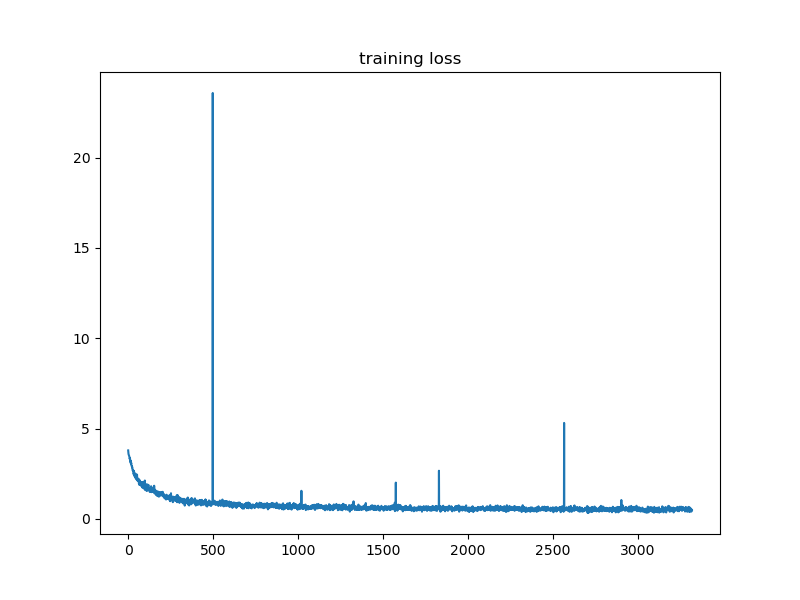

In [28]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")
plt.show()

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
#     tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_loader.dataset):
    try:
        output = predict(waveform)
        if output != utterance:
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
            break
        else:
            print("All examples in this dataset were correctly classified!")
            print("In this case, let's just look at the last data point")
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
    except:
        # model fails on short wav because of no padding
        print('{} failed'.format(i))
        print(waveform.size())

In [29]:
# ### save model
# model_name = 'sample_FGN_model_SPEECHCOMMANDS'
# save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'
# print('Saving trained model {} in {}'.format(model_name, save_path))

# # save model entirely
# torch.save(model, save_path+model_name+'_full.pth')

# # save model weights
# torch.save(model.state_dict(), save_path+model_name+'_state_dict.pth')



Saving trained model sample_FGN_model_SPEECHCOMMANDS in ../Experiments/sample_SPEECHCOMMANDS_models/


In [ ]:
# check model trained for 10 epochs

In [22]:
model_name = 'sample_FGN_model_SPEECHCOMMANDS'
save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'

model.load_state_dict(torch.load(save_path+model_name+'_state_dict.pth'))

<All keys matched successfully>

In [23]:
fgnl.sigmas_loss(model, covar_type='sphere')

tensor([40.5481], grad_fn=<DivBackward0>)

In [31]:
test(model, epoch)


Test Epoch: 10	Accuracy: 8217/11005 (75%)



In [30]:
model.state_dict()

OrderedDict([('fgn_conv1.centers',
              tensor([[-9.3117e-02, -1.1540e-01, -4.1572e-02,  ...,  1.1200e-01,
                        1.9667e-01,  3.8031e-01],
                      [ 1.3463e-01,  6.6367e-02, -9.5115e-02,  ...,  2.1746e-01,
                        2.8355e-01,  4.5724e-02],
                      [ 3.0849e-04, -1.5215e-02,  2.6351e-02,  ...,  3.4992e-02,
                       -9.6924e-02, -1.3013e-01],
                      ...,
                      [-6.5296e-03, -1.1705e-02, -3.2039e-01,  ...,  2.0510e-01,
                        9.3954e-03, -2.3058e-01],
                      [ 4.8722e-02,  7.1619e-03, -4.4251e-02,  ..., -5.6931e-04,
                       -1.9807e-02,  9.2352e-03],
                      [ 9.5337e-02, -2.2999e-02, -3.5808e-02,  ..., -5.0758e-02,
                       -6.5317e-02, -3.3170e-01]])),
             ('fgn_conv1.inv_covars',
              tensor([[0.4776, 0.3921, 0.2520,  ..., 0.6025, 0.6397, 0.7024],
                      [0.2915, 0.